In [21]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score
import sqlite3
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Establish a connection to the SQLite database
db_path = "/content/restaurant.sqlite"
conn = sqlite3.connect(db_path)

In [23]:
# Read data from the "restaurants" table into a DataFrame
query = "SELECT * FROM restaurants"  # Use the correct table name
df_stocks = pd.read_sql_query(query, conn)

# New Section

In [24]:
# Close the database connection
conn.close()

In [25]:
# Convert 'Risk' column to numerical using LabelEncoder
label_encoder = LabelEncoder()
df_stocks["Risk"] = label_encoder.fit_transform(df_stocks["Risk"].fillna("Unknown"))  # Fill NaNs with 'Unknown'

In [26]:
# Select relevant features for prediction
features = ["Results", "zip"]  # Use "Results" column and "Zip" feature for prediction
X = df_stocks[features]
y = df_stocks["Risk"]

In [27]:
# Convert categorical features to numerical using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=["Results", "zip"], drop_first=True)  # Keep only "Results" values and "Zip" codes

In [28]:
# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_encoded_imputed = imputer.fit_transform(X_encoded)

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_imputed, y, test_size=0.2, random_state=42)

In [30]:
# Initialize and train the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
model_path = "trained_model.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print('Model Saved to Disk')

Model Saved to Disk


In [32]:
# Make predictions using the trained model
y_pred = model.predict(X_test)

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [34]:
# Calculate normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [35]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

In [36]:
# Define custom class labels
custom_labels = label_encoder.classes_

In [37]:
# Save metrics and labels to a JSON file
metrics_and_labels = {
    "confusion_matrix": cm.tolist(),
    "accuracy": accuracy,
    "custom_labels": custom_labels.tolist()
}

with open("metrics.json", "w") as metrics_file:
    json.dump(metrics_and_labels, metrics_file)

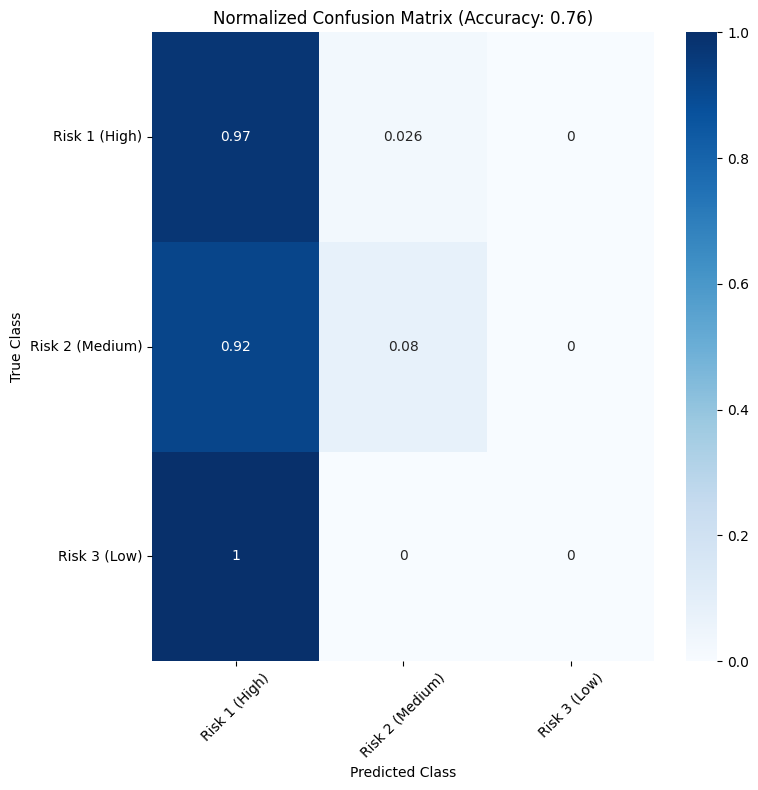

In [38]:
# Create a heatmap of the normalized confusion matrix with accuracy
plt.figure(figsize=(8, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
plt.title(f"Normalized Confusion Matrix (Accuracy: {accuracy:.2f})")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(np.arange(len(custom_labels)) + 0.5, custom_labels, rotation=45)
plt.yticks(np.arange(len(custom_labels)) + 0.5, custom_labels, rotation=0)
plt.tight_layout()
plt.show()